<a href="https://colab.research.google.com/github/mawga2/personal/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Regression

## Setup

In [ ]:
pip install -q category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/car_prices.csv')

## Preprocessing

In [ ]:
df.dropna(inplace=True)
df.drop(['vin', 'saledate', 'trim', 'state', 'seller'], axis=1, inplace=True)

In [ ]:
df

In [ ]:
df.dtypes

In [ ]:
unique_counts = df.nunique()
unique_counts

In [ ]:
#target encoding for 'year'
target_encoder = TargetEncoder()
sellingprice_mean = df.groupby('year')['sellingprice'].mean()
df_quantized = df.copy()
df_quantized = pd.merge(df_quantized, sellingprice_mean, on='year', suffixes=('', '_mean'))
df_quantized.rename(columns={'sellingprice_mean': 'target'}, inplace=True)
df_quantized.drop(columns=['year'], inplace=True)

In [ ]:
#ordinal encoding for 'make', 'color', 'interior', 'model, 'body'
label_encoder = LabelEncoder()
df_quantized['make'] = label_encoder.fit_transform(df_quantized['make'])
df_quantized['color'] = label_encoder.fit_transform(df_quantized['color'])
df_quantized['interior'] = label_encoder.fit_transform(df_quantized['interior'])
df_quantized['model'] = label_encoder.fit_transform(df_quantized['model'])
df_quantized['body'] = label_encoder.fit_transform(df_quantized['body'])

In [ ]:
#one-hot encoding for 'transmission'
onehot_encoded = pd.get_dummies(df_quantized['transmission'], prefix='transmission')
df_quantized.drop(columns=['transmission'], inplace=True)
df_quantized = pd.concat([df_quantized, onehot_encoded], axis=1)
df_quantized['transmission_automatic'] = df_quantized['transmission_automatic'].astype(int)
df_quantized.rename(columns={'transmission_automatic': 'transmission'}, inplace=True)
df_quantized.drop(columns=['transmission_manual'], inplace=True)

In [ ]:
#standardization for 'condition'
scaler = StandardScaler()
df_quantized['condition_standardized'] = scaler.fit_transform(df_quantized[['condition']])
df_quantized.drop(columns=['condition'], inplace=True)

In [ ]:
df_quantized

In [ ]:
y = df_quantized['sellingprice']

feature_columns = ['make', 'model', 'body', 'transmission',
                   'odometer', 'color', 'interior', 'target',
                   'mmr', 'condition_standardized']
X = df_quantized[feature_columns]

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [ ]:
while True:
    max_p_value = max(model.pvalues)
    if max_p_value > 0.05:
        index_to_remove = np.argmax(model.pvalues[1:])
        X = X.drop(X.columns[index_to_remove], axis=1)
        model = sm.OLS(y, X).fit()
    else:
        break

In [ ]:
print(model.summary())

In [ ]:
selected_variables = X.columns.tolist()
print("Selected variables:", selected_variables)

In [ ]:
#Check for multicolinearity
correlation_matrix = X.corr()

highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            if colname_i not in highly_correlated:
                highly_correlated.add(colname_j)

X.drop(columns=highly_correlated, inplace=True)

In [ ]:
print(highly_correlated)

In [ ]:
#Determine alpha value
alphas = [21115, 21116, 21117, 21130]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X, y)

best_alpha = ridge_cv.alpha_
print("Best alpha value:", best_alpha)

In [ ]:
#Ridge regression
ridge = Ridge(alpha=best_alpha)
ridge.fit(X, y)
print("Coefficients after regularization:", ridge.coef_)

In [ ]:
#Confidence interval
n_bootstrap = 1000
coefficients_bootstrapped = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(X, y)
    ridge_boot = Ridge(alpha=21116)
    ridge_boot.fit(X_boot, y_boot)
    coefficients_bootstrapped.append(ridge_boot.coef_)

confidence_intervals = np.percentile(coefficients_bootstrapped, [2.5, 97.5], axis=0)

print("95% Confidence Intervals for Coefficients:")
for i, column in enumerate(X.columns):
    print(f"{column}: {confidence_intervals[:, i]}")

## Regression models

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

xgb_regressor = XGBRegressor(random_state=1)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

In [ ]:
#Results
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R² score: {r2_score(y_test, y_pred)}')

# Exploratory Data Analysis

## Setup

In [ ]:
!pip install -q -U kaleido

In [ ]:
!pip install -q plotly

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [ ]:
palette = sns.color_palette('husl')
colours = iter(palette)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/car_prices.csv')
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

## Visualization

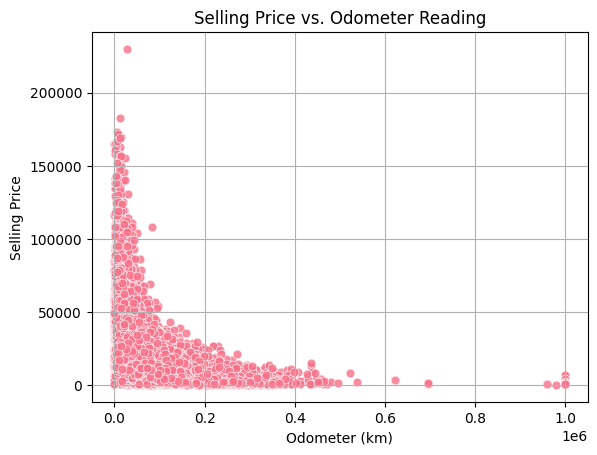

In [ ]:
sns.scatterplot(data, x="odometer", y="sellingprice", color=next(colours), s=40, alpha=0.8)
plt.xlabel("Odometer (km)")
plt.ylabel("Selling Price")
plt.title("Selling Price vs. Odometer Reading")
plt.grid(True)

plt.show()

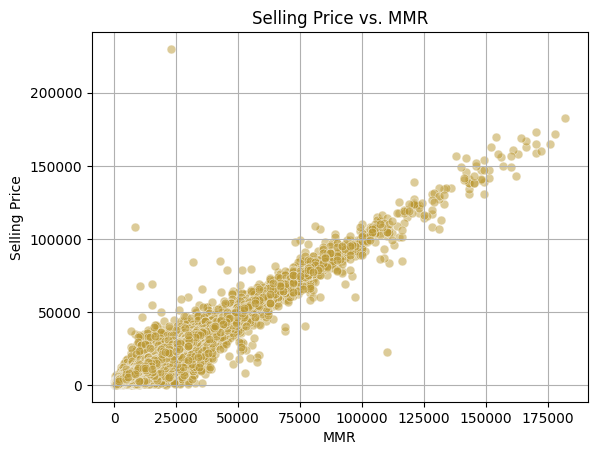

In [ ]:
sns.scatterplot(data, x="mmr", y="sellingprice", color=next(colours), s=40, alpha=0.5)
plt.xlabel("MMR")
plt.ylabel("Selling Price")
plt.title("Selling Price vs. MMR")
plt.grid(True)

plt.show()

In [ ]:
filtered_data = data[data["color"] != "—"]
colour = filtered_data['color'].value_counts()
fig = go.Figure(data=[go.Pie(labels=colour.index, values=colour.values)])
fig.update_layout(title_text='Exterior Colour Preference Among Customers Pie Chart')
fig.show()

In [ ]:
filtered_data = data[data["color"] != "—"]
interior = filtered_data['interior'].value_counts()
fig = go.Figure(data=[go.Pie(labels=interior.index, values=interior.values)])
fig.update_layout(title_text='Interior Colour Preference Among Customers Pie Chart')
fig.show()

<ipython-input-21-e9382c37e974>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




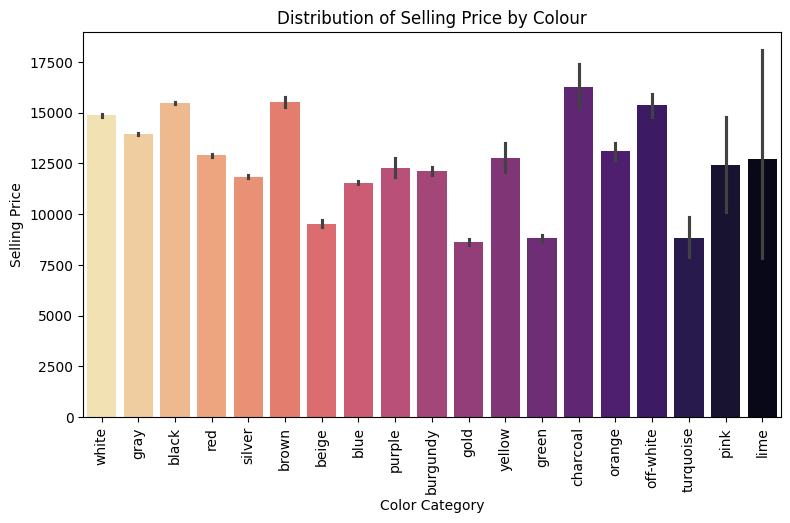

In [ ]:
filtered_data = data[data["color"] != "—"]

plt.figure(figsize=(9, 5))
sns.barplot(
    filtered_data,
    x="color",
    y="sellingprice",
    palette='magma_r',
)
plt.xlabel("Color Category")
plt.ylabel("Selling Price")
plt.title("Distribution of Selling Price by Colour")

plt.xticks(rotation=90)

plt.show()

<ipython-input-22-2fa2e5cf8022>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




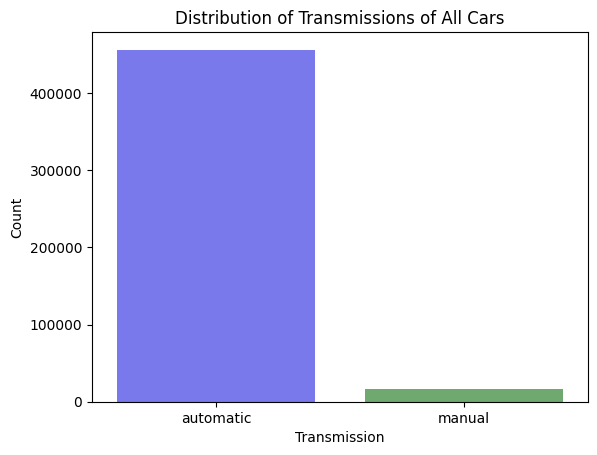

In [ ]:
transmission_counts = data['transmission'].value_counts()
sns.barplot(x=transmission_counts.index, y=transmission_counts.values, palette=['blue', 'green'], alpha=0.6)
plt.title("Distribution of Transmissions of All Cars")
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.show()

In [ ]:
YT = pd.crosstab(data["year"], data["transmission"])
px.line(YT,title= "Distribution of Transmission Sales of All Cars")

<ipython-input-24-40de85737470>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




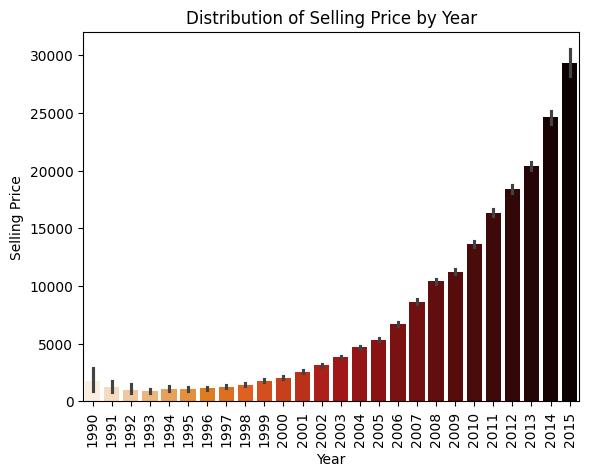

In [ ]:
data_seller = data.groupby(by=["seller", "year"], as_index=False)[
    "sellingprice"
].first()
data_seller.sort_values(by="sellingprice", ascending=False, inplace=True)

sns.barplot(
    data_seller,
    x="year",
    y="sellingprice",
    palette="gist_heat_r",
)
plt.title("Distribution of Selling Price by Year")
plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.xticks(rotation=90)
plt.show()

<ipython-input-25-24184b9b5ae6>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-24184b9b5ae6>:5: FutureWarning:



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.




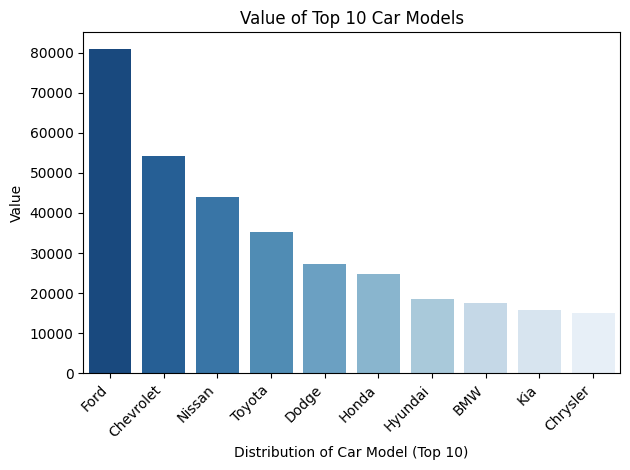

In [ ]:
values = data["make"].value_counts().sort_values(ascending=False)
val = values.values
model = values.index

sns.barplot(
    x=model[0:10],
    y=val[0:10],
    palette="Blues_r",
    errwidth=2,
    capsize=7,
)

plt.xlabel("Distribution of Car Model (Top 10)")
plt.ylabel("Value")
plt.title("Value of Top 10 Car Models")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

<ipython-input-26-3af3608c972f>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-26-3af3608c972f>:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-26-3af3608c972f>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-26-3af3608c972f>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



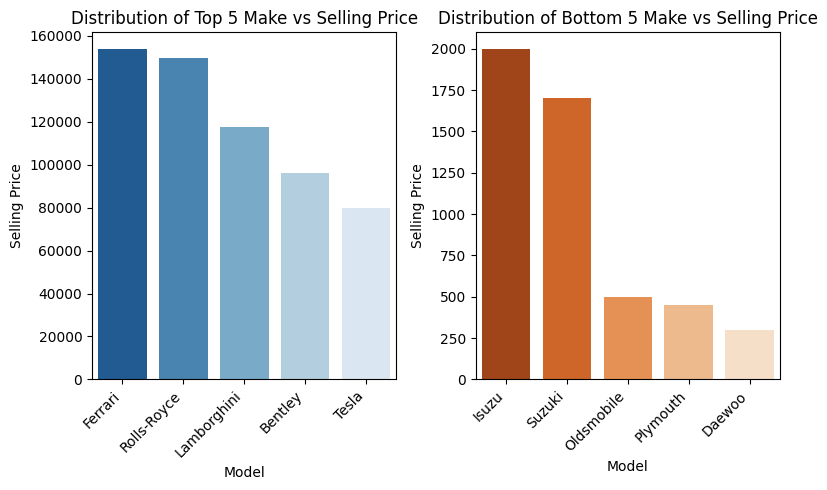

In [ ]:
data_make_price = data.groupby(by="make", as_index=False)["sellingprice"].first()
data_make_price.sort_values(by="sellingprice", ascending=False, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

sns.barplot(data=data_make_price[0:5], x="make", y="sellingprice", ax=axs[0], palette='Blues_r')
axs[0].set_title("Distribution of Top 5 Make vs Selling Price")
axs[0].set_xlabel("Model")
axs[0].set_ylabel("Selling Price")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha="right")

sns.barplot(data=data_make_price[-6:-1], x="make", y="sellingprice", ax=axs[1],palette='Oranges_r')
axs[1].set_title("Distribution of Bottom 5 Make vs Selling Price")
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Selling Price")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

<ipython-input-27-4ca769a6d474>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




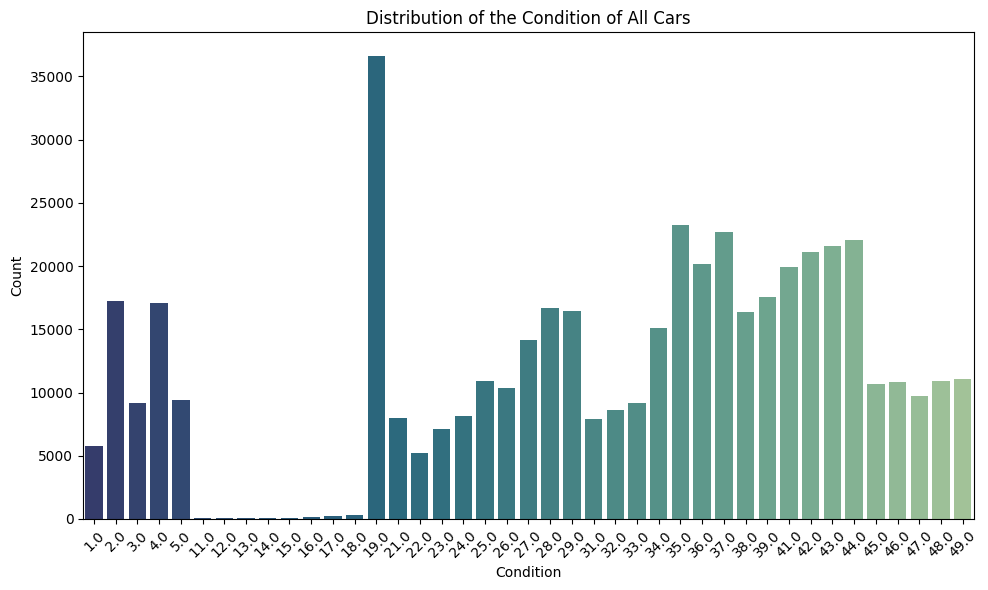

In [ ]:
condition = data['condition'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=condition.index, y=condition.values, palette='crest_r')
plt.title("Distribution of the Condition of All Cars")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data_condition_make = pd.crosstab(data["condition"], data["make"])
px.line(data_condition_make, title= "Distribution of the Model Relative to the Condition of All Cars")